In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import datetime as dt
import requests
 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Set up parameters of the project

# Stock or cryptocurrency pair that the script will fecth from the API of Yahoo Finance
asset = "GOOG"

# Training data start date
start = dt.datetime(2010,8,3).strftime('%s')

# Training data end date
end = dt.datetime(2021,1,1).strftime('%s')

# Test data start date
test_start = dt.datetime(2021,1,1).strftime('%s')

# Test data end date
test_end = dt.datetime.now().strftime('%s')

# Long term memory of the model measured in prediction days
prediction_days = 30

# Fetching training data from the Yahoo Finance API, with daily frequency and then deleting the rows that have NaN values so we train the model using clean data.
data = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{asset}?period1={start}&period2={end}&interval=1d&events=history&crumb=ydacXMYhzrn').dropna()
 
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-03,244.334183,245.310516,242.471161,244.000427,244.000427,3618111
1,2010-08-04,245.171036,252.553375,244.608154,252.214645,252.214645,7653580
2,2010-08-05,252.000443,253.350388,250.839798,253.101318,253.101318,4858945
3,2010-08-06,251.756348,251.925720,247.098816,249.176025,249.176025,6663885
4,2010-08-09,250.187241,251.806168,249.743896,251.731445,251.731445,3758435
...,...,...,...,...,...,...,...
2618,2020-12-24,1735.000000,1746.000000,1729.109985,1738.849976,1738.849976,346800
2619,2020-12-28,1751.635010,1790.728027,1746.334961,1776.089966,1776.089966,1393000
2620,2020-12-29,1787.790039,1792.439941,1756.089966,1758.719971,1758.719971,1299400
2621,2020-12-30,1762.010010,1765.094971,1725.599976,1739.520020,1739.520020,1306100


Epoch 1/25
82/82 [==============================] - 9s 44ms/step - loss: 0.0350
Epoch 2/25
82/82 [==============================] - 4s 44ms/step - loss: 0.0262
Epoch 3/25
82/82 [==============================] - 4s 46ms/step - loss: 0.0207
Epoch 4/25
82/82 [==============================] - 4s 45ms/step - loss: 0.0175
Epoch 5/25
82/82 [==============================] - 4s 44ms/step - loss: 0.0151
Epoch 6/25
82/82 [==============================] - 4s 46ms/step - loss: 0.0147
Epoch 7/25
82/82 [==============================] - 4s 45ms/step - loss: 0.0132
Epoch 8/25
82/82 [==============================] - 4s 44ms/step - loss: 0.0134
Epoch 9/25
82/82 [==============================] - 4s 43ms/step - loss: 0.0150
Epoch 10/25
82/82 [==============================] - 4s 44ms/step - loss: 0.0128
Epoch 11/25
82/82 [==============================] - 4s 46ms/step - loss: 0.0127
Epoch 12/25
82/82 [==============================] - 4s 44ms/step - loss: 0.0125
Epoch 13/25
82/82 [==================

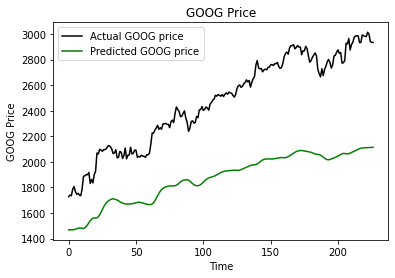

In [ ]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # Closing price
 
x_train = []
y_train = []
 
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
 
# Build The Model
model = Sequential()
 
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=1))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next closing price
 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)
 
# model.save()
 
''' Test The Model Accuracy on Existing Data '''
 
# Load Test Data
test_data = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{asset}?period1={test_start}&period2={test_end}&interval=1d&events=history&crumb=ydacXMYhzrn').dropna() 
actual_prices = test_data['Close'].values
 
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
 
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)
 
# Make Predictions on Test Data
 
x_test = []
 
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
 
# Plot The Test Predictions
plt.plot(actual_prices, color="black", label=f"Actual {asset} price")
plt.plot(predicted_prices, color="green", label=f"Predicted {asset} price")
plt.title(f"{asset} Price")
 
plt.xlabel('Time')
plt.ylabel(f"{asset} Price")
plt.legend()
plt.show()